In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import warnings

# Filter warnings for cleaner output
warnings.filterwarnings('ignore')


In [ ]:
# ==========================================
# 1. Configuration
# ==========================================
class Config:
    # File Path
    FILE_PATH = '../preprocess/df_g2_processed.pkl'
    ASSETS = ['XAU', 'XAG']

    # Contract Specifications
    # XAU: Gold ($100 per point), XAG: Silver ($5000 per point)
    SPECS = {
        'XAU': {'point_val': 100.0, 'cost': 15.0},
        'XAG': {'point_val': 5000.0, 'cost': 10.0}
    }

    # Strategy Parameters (Cointegration / Pairs Trading)
    # Window to calculate the Hedge Ratio (Beta) - e.g., ~1 week of 5-min bars
    WINDOW_BETA = 1500

    # Window to calculate the Z-Score of the Spread
    WINDOW_Z = 300

    # Thresholds for Signal Generation (Z-Score)
    ENTRY_THRESHOLD = 2.0  # Enter trade if Z > 2 or Z < -2
    EXIT_THRESHOLD = 0.5   # Exit trade if |Z| < 0.5 (Mean Reversion)

    # Annualization factor for statistics
    ANNUALIZATION = 252

In [ ]:
# ==========================================
# 2. Data Preparation & Cointegration Indicators
# ==========================================
def prepare_pairs_data(file_path, cfg):
    """
    Loads data and calculates Rolling Beta and Z-Score for the pair.
    """
    try:
        df = pd.read_pickle(file_path)
    except FileNotFoundError:
        print("Error: File not found.")
        return None

    # Check for required columns
    req_cols = cfg.ASSETS + ['Quarter_ID']
    if 'Is_In_Sample' in df.columns:
        req_cols.append('Is_In_Sample')

    data = df[req_cols].copy()

    # Handle Out-of-Sample Logic (Default to True if column missing)
    if 'Is_In_Sample' not in data.columns:
        data['Is_In_Sample'] = True

    print("Calculating Rolling Hedge Ratio and Z-Score...")

    # --- Helper Function for Group-wise Calculation ---
    def calc_cointegration_metrics(group):
        # We perform regression on 'Dollar Values' (Notional) to account for contract size diffs
        # Y = XAU (Gold) Value
        # X = XAG (Silver) Value
        # Equation: Y = Beta * X + epsilon

        y = group['XAU'] * cfg.SPECS['XAU']['point_val']
        x = group['XAG'] * cfg.SPECS['XAG']['point_val']

        # 1. Rolling OLS to find Beta (Hedge Ratio)
        # Formula: Beta = Cov(x, y) / Var(x)
        cov = x.rolling(window=cfg.WINDOW_BETA).cov(y)
        var = x.rolling(window=cfg.WINDOW_BETA).var()
        beta = cov / var

        # 2. Calculate Spread (Residuals)
        # Spread = Y - Beta * X
        spread = y - (beta * x)

        # 3. Calculate Z-Score of the Spread
        # Z = (Spread - Mean(Spread)) / Std(Spread)
        spread_mean = spread.rolling(window=cfg.WINDOW_Z).mean()
        spread_std = spread.rolling(window=cfg.WINDOW_Z).std()
        z_score = (spread - spread_mean) / spread_std

        # Assign to group
        group['Beta'] = beta
        group['Spread'] = spread
        group['Z_Score'] = z_score

        return group

    # Apply calculation per Quarter to prevent data leakage across OOS periods
    # group_keys=False keeps the original index
    data = data.groupby('Quarter_ID', group_keys=False).apply(calc_cointegration_metrics)

    # Drop initial NaNs generated by rolling windows
    data.dropna(subset=['Z_Score'], inplace=True)

    return data

In [ ]:
# ==========================================
# 3. Strategy Logic (Signal Execution)
# ==========================================
def run_pairs_strategy(df, cfg):
    """
    Executes trades based on Z-Score signals.
    Enforces 1-unit constraint per asset.
    """
    data = df.copy()

    # Arrays for fast iteration
    z_scores = data['Z_Score'].values
    in_sample = data['Is_In_Sample'].values

    # Output arrays for Positions (1, 0, -1)
    pos_xau = np.zeros(len(data), dtype=int)
    pos_xag = np.zeros(len(data), dtype=int)

    # State Variables
    curr_pos_xau = 0
    curr_pos_xag = 0

    print(f"Simulating Pairs Strategy (Entry Z: {cfg.ENTRY_THRESHOLD}, Exit Z: {cfg.EXIT_THRESHOLD})...")

    for i in range(len(data)):
        # 1. Skip if Out-of-Sample (OOS)
        if not in_sample[i]:
            curr_pos_xau = 0
            curr_pos_xag = 0
            pos_xau[i] = 0
            pos_xag[i] = 0
            continue

        z = z_scores[i]

        # 2. Trading Logic

        # CASE A: No Position
        if curr_pos_xau == 0:
            # Signal: Spread is too HIGH (Gold expensive / Silver cheap)
            # Action: Sell Gold, Buy Silver
            if z > cfg.ENTRY_THRESHOLD:
                curr_pos_xau = -1
                curr_pos_xag = 1

            # Signal: Spread is too LOW (Gold cheap / Silver expensive)
            # Action: Buy Gold, Sell Silver
            elif z < -cfg.ENTRY_THRESHOLD:
                curr_pos_xau = 1
                curr_pos_xag = -1

        # CASE B: Holding Positions
        else:
            # Exit Condition: Mean Reversion
            # If Z-Score returns inside the Exit Threshold band
            if abs(z) < cfg.EXIT_THRESHOLD:
                curr_pos_xau = 0
                curr_pos_xag = 0

            # Note: We stick to the position until mean reversion.
            # (Optional: Add Stop Loss logic here if needed)

        # 3. Update Position Arrays
        pos_xau[i] = curr_pos_xau
        pos_xag[i] = curr_pos_xag

    # Shift positions by 1 to simulate execution at the next bar (avoid look-ahead bias)
    data['Pos_XAU'] = pd.Series(pos_xau, index=data.index).shift(1).fillna(0)
    data['Pos_XAG'] = pd.Series(pos_xag, index=data.index).shift(1).fillna(0)

    return data

Calculating Rolling Hedge Ratio and Z-Score...
Simulating Pairs Strategy (Entry Z: 2.0, Exit Z: 0.5)...

 PERFORMANCE REPORT: Cointegration Spread Strategy

[Text Output]
   Quarter  Gross SR    Net SR  Ann. Vol ($)   Gross CR     Net CR  Gross CumP&L  Net CumP&L  Trades (Au)  Trades (Ag)  Av. Trades       Stat
0  2023_Q1 -2.920495 -3.182460  16573.448890  -2.341927  -2.436183      -13241.9    -14441.9         48.0         48.0    1.391304  -9.832659
1  2023_Q3  0.401289  0.139486  13629.757233   0.909779   0.310561        1528.1       528.1         40.0         40.0    1.142857  -0.000000
2  2023_Q4  0.147066 -0.128555  15653.943845   0.323842  -0.271005         641.0      -559.0         48.0         48.0    1.371429  -0.000000
3  2024_Q2  0.750865  0.518929  24412.777940   1.338905   0.912256        5144.3      3569.3         63.0         63.0    1.774648   0.024085
4  2024_Q4 -0.052234 -0.135418  46297.838360  -0.492379  -1.250883        -691.3     -1791.3         44.0         44.0 

,Quarter,Gross SR,Net SR,Ann. Vol ($),Gross CR,Net CR,Gross CumP&L,Net CumP&L,Trades (Au),Trades (Ag),Av. Trades,Stat
0,2023_Q1,-2.92,-3.18,"$16,573",-2.34,-2.44,"$-13,242","$-14,442",48,48,1.4,-9.8327
1,2023_Q3,0.40,0.14,"$13,630",0.91,0.31,"$1,528",$528,40,40,1.1,-0.0000
2,2023_Q4,0.15,-0.13,"$15,654",0.32,-0.27,$641,$-559,48,48,1.4,-0.0000
3,2024_Q2,0.75,0.52,"$24,413",1.34,0.91,"$5,144","$3,569",63,63,1.8,0.0241
4,2024_Q4,-0.05,-0.14,"$46,298",-0.49,-1.25,$-691,"$-1,791",44,44,1.2,-0.3704
5,2025_Q1,5.05,4.86,"$20,320",17.60,16.69,"$28,042","$27,042",40,40,1.2,14.3778
6,2025_Q2,3.91,3.80,"$52,198",17.48,16.79,"$57,385","$55,935",58,58,1.6,13.2936
7,TOTAL,-,-,"$31,043",-,-,"$78,807","$70,282",341,341,1.4,17.4923



 TOTAL RANKING SCORE: 17.4923


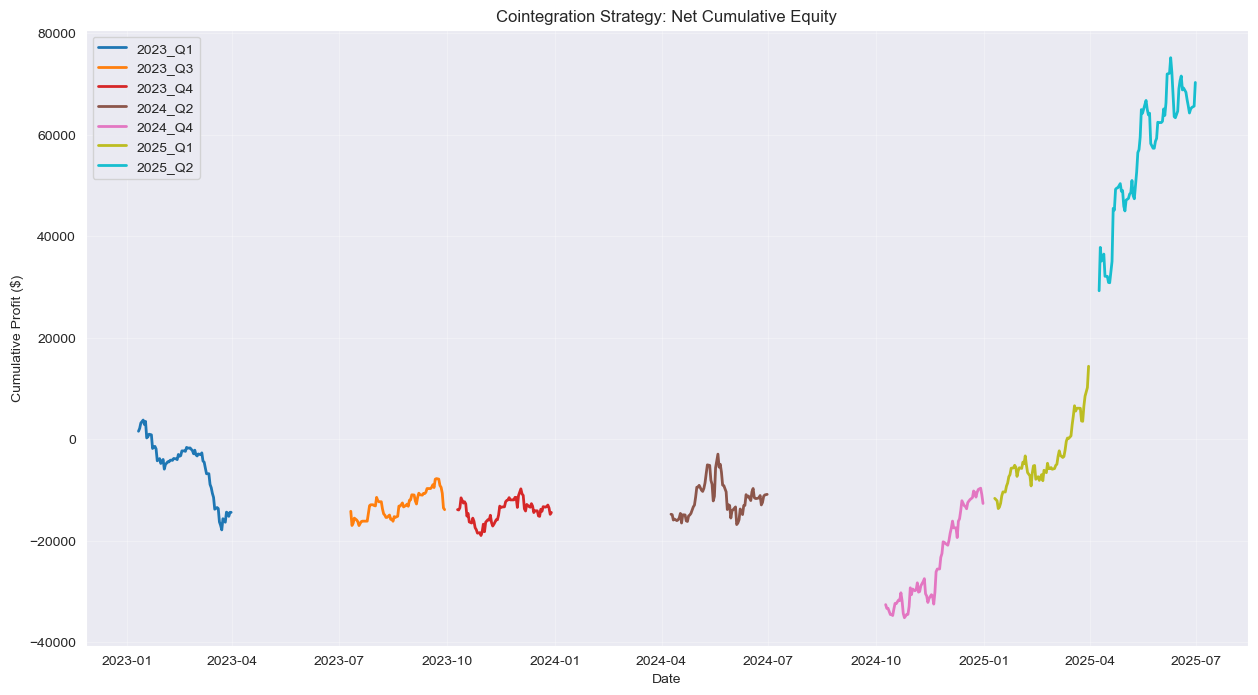

In [1]:
# ==========================================
# 4. P&L Calculation & Aggregation
# ==========================================
def calculate_metrics(data, cfg):
    """
    Calculates P&L, Costs, and Aggregates to Daily frequency.
    """
    df = data.copy()

    # Calculate Price Differences
    df['dPrice_XAU'] = df['XAU'].diff()
    df['dPrice_XAG'] = df['XAG'].diff()

    # Calculate Gross P&L (Position * Price Change * Multiplier)
    df['Gross_PnL_XAU'] = df['Pos_XAU'] * df['dPrice_XAU'] * cfg.SPECS['XAU']['point_val']
    df['Gross_PnL_XAG'] = df['Pos_XAG'] * df['dPrice_XAG'] * cfg.SPECS['XAG']['point_val']
    df['Gross_PnL_Total'] = df['Gross_PnL_XAU'] + df['Gross_PnL_XAG']

    # Calculate Trades (Turnover) for Cost
    df['Trades_XAU'] = df['Pos_XAU'].diff().abs().fillna(0)
    df['Trades_XAG'] = df['Pos_XAG'].diff().abs().fillna(0)

    # Calculate Costs
    df['Cost_Total'] = (df['Trades_XAU'] * cfg.SPECS['XAU']['cost']) + \
                       (df['Trades_XAG'] * cfg.SPECS['XAG']['cost'])

    # Calculate Net P&L
    df['Net_PnL_Total'] = df['Gross_PnL_Total'] - df['Cost_Total']
    df['Total_Trades'] = df['Trades_XAU'] + df['Trades_XAG']

    # Resample to Daily Aggregation
    daily_stats = df.resample('D').agg({
        'Gross_PnL_Total': 'sum',
        'Net_PnL_Total': 'sum',
        'Total_Trades': 'sum',
        'Trades_XAU': 'sum',
        'Trades_XAG': 'sum',
        'Quarter_ID': 'last',
        'Is_In_Sample': 'last'
    })

    # Filter valid days
    daily_stats = daily_stats[daily_stats['Quarter_ID'].notna()]
    daily_stats = daily_stats[daily_stats['Is_In_Sample'] == True]

    return daily_stats



In [ ]:
# ==========================================
# 5. Performance Stats & Reporting
# ==========================================
def generate_quarterly_stats(daily_df, cfg):
    """
    Generates summary statistics per Quarter.
    """
    if daily_df.empty:
        return pd.DataFrame()

    quarters = sorted(daily_df['Quarter_ID'].unique())
    stats_list = []

    for q in quarters:
        d_q = daily_df[daily_df['Quarter_ID'] == q].copy()

        if len(d_q) == 0:
            continue

        # --- Metrics Calculation ---
        gross_cum_pnl = d_q['Gross_PnL_Total'].sum()
        net_cum_pnl = d_q['Net_PnL_Total'].sum()

        # Sharpe Ratio
        mean_g = d_q['Gross_PnL_Total'].mean()
        std_g = d_q['Gross_PnL_Total'].std()
        gross_sr = (mean_g / std_g * np.sqrt(cfg.ANNUALIZATION)) if std_g != 0 else 0

        mean_n = d_q['Net_PnL_Total'].mean()
        std_n = d_q['Net_PnL_Total'].std()
        net_sr = (mean_n / std_n * np.sqrt(cfg.ANNUALIZATION)) if std_n != 0 else 0

        # Volatility ($)
        ann_vol_n = std_n * np.sqrt(cfg.ANNUALIZATION)

        # Calmar Ratio
        years = len(d_q) / cfg.ANNUALIZATION

        equity_g = d_q['Gross_PnL_Total'].cumsum()
        max_dd_g = (equity_g.cummax() - equity_g).max()
        annualized_pnl_g = gross_cum_pnl / years if years > 0 else 0
        gross_cr = (annualized_pnl_g / max_dd_g) if (max_dd_g is not None and max_dd_g > 0) else 0

        equity_n = d_q['Net_PnL_Total'].cumsum()
        max_dd_n = (equity_n.cummax() - equity_n).max()
        annualized_pnl_n = net_cum_pnl / years if years > 0 else 0
        net_cr = (annualized_pnl_n / max_dd_n) if (max_dd_n is not None and max_dd_n > 0) else 0

        # Trades
        trades_xau = d_q['Trades_XAU'].sum()
        trades_xag = d_q['Trades_XAG'].sum()
        av_ntrades = d_q['Total_Trades'].mean()

        # Summary Statistic Formula
        abs_pnl_scaled = abs(net_cum_pnl) / 1000.0
        log_term = np.log(abs_pnl_scaled) if abs_pnl_scaled > 0 else 0
        term_2 = max(0, log_term)
        stat = (net_sr - 0.5) * term_2

        stats_list.append({
            'Quarter': q,
            'Gross SR': gross_sr,
            'Net SR': net_sr,
            'Ann. Vol ($)': ann_vol_n,
            'Gross CR': gross_cr,
            'Net CR': net_cr,
            'Gross CumP&L': gross_cum_pnl,
            'Net CumP&L': net_cum_pnl,
            'Trades (Au)': trades_xau,
            'Trades (Ag)': trades_xag,
            'Av. Trades': av_ntrades,
            'Stat': stat
        })

    stats_df = pd.DataFrame(stats_list)
    return stats_df

def plot_equity_curve(daily_stats):
    """
    Plots the cumulative equity curve.
    """
    if daily_stats is None or daily_stats.empty:
        return

    quarters = sorted(daily_stats['Quarter_ID'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(quarters)))

    plt.figure(figsize=(15, 8))

    # Calculate Global Cumulative PnL
    daily_stats['Global_Equity'] = daily_stats['Net_PnL_Total'].cumsum()

    for i, q in enumerate(quarters):
        d_q = daily_stats[daily_stats['Quarter_ID'] == q]
        plt.plot(d_q.index, d_q['Global_Equity'], label=q, color=colors[i], lw=2)

    plt.title('Cointegration Strategy: Net Cumulative Equity')
    plt.ylabel('Cumulative Profit ($)')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()



In [ ]:
# ==========================================
# 6. Main Execution
# ==========================================
if __name__ == "__main__":
    # 1. Initialize Configuration
    cfg = Config()

    # 2. Prepare Data
    df_prep = prepare_pairs_data(cfg.FILE_PATH, cfg)

    if df_prep is not None:
        # 3. Run Strategy Logic
        df_res = run_pairs_strategy(df_prep, cfg)

        # 4. Calculate Daily Metrics
        daily_data = calculate_metrics(df_res, cfg)

        # 5. Generate Stats Table
        stats_table = generate_quarterly_stats(daily_data, cfg)

        # --- Display Results ---
        print("\n" + "="*80)
        print(" PERFORMANCE REPORT: Cointegration Spread Strategy")
        print("="*80)

        if not stats_table.empty:
            # Calculate Total Aggregates
            total_score = stats_table['Stat'].sum()
            total_gross_pnl = stats_table['Gross CumP&L'].sum()
            total_net_pnl = stats_table['Net CumP&L'].sum()
            total_trades_au = stats_table['Trades (Au)'].sum()
            total_trades_ag = stats_table['Trades (Ag)'].sum()

            # Global Volatility
            std_global = daily_data['Net_PnL_Total'].std()
            vol_global = std_global * np.sqrt(cfg.ANNUALIZATION)

            # Create Display DataFrame with Total Row
            display_df = stats_table.copy()
            sum_row = pd.DataFrame([{
                'Quarter': 'TOTAL',
                'Gross SR': np.nan,
                'Net SR': np.nan,
                'Ann. Vol ($)': vol_global,
                'Gross CR': np.nan,
                'Net CR': np.nan,
                'Gross CumP&L': total_gross_pnl,
                'Net CumP&L': total_net_pnl,
                'Trades (Au)': total_trades_au,
                'Trades (Ag)': total_trades_ag,
                'Av. Trades': stats_table['Av. Trades'].mean(),
                'Stat': total_score
            }])

            display_df = pd.concat([display_df, sum_row], ignore_index=True)

            # Define Formatting
            format_dict = {
                'Gross SR': '{:.2f}', 'Net SR': '{:.2f}',
                'Ann. Vol ($)': '${:,.0f}',
                'Gross CR': '{:.2f}', 'Net CR': '{:.2f}',
                'Gross CumP&L': '${:,.0f}', 'Net CumP&L': '${:,.0f}',
                'Trades (Au)': '{:,.0f}', 'Trades (Ag)': '{:,.0f}',
                'Av. Trades': '{:.1f}',
                'Stat': '{:.4f}'
            }

            # Text Output (Fallback)
            print("\n[Text Output]")
            print(display_df.to_string(formatters={k: v.format for k, v in format_dict.items() if isinstance(v, str) == False}, na_rep="-"))

            # HTML Table Output (for Notebook)
            print("\n[Table Output]")
            try:
                subset_stat = pd.IndexSlice[0:len(display_df)-2, ['Stat']]
                styled_df = display_df.style.format(format_dict, na_rep="-")\
                                            .background_gradient(subset=subset_stat, cmap='RdYlGn')\
                                            .apply(lambda x: ['font-weight: bold' if x.name == len(display_df)-1 else '' for i in x], axis=1)
                display(styled_df)
            except Exception as e:
                print(f"(Display error: {e})")
                display(display_df)

            print(f"\n{'='*40}")
            print(f" TOTAL RANKING SCORE: {total_score:.4f}")
            print(f"{'='*40}")
        else:
            print("⚠️ No statistics generated.")

        # 6. Plot Equity Curve
        plot_equity_curve(daily_data)